<a href="https://colab.research.google.com/github/arun-arunisto/OpenCVTutorial/blob/todo/ComputerVisionTutorial14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Real-time Multi-Person 2D pose detection using Part Affinity Fields (2017)

In [9]:
#importing libraries
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

In [3]:
#downloading assets this code will automatically
#download the caffe model and other needed libraries
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/089r2yg6aao858l/opencv_bootcamp_assets_NB14.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB14.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

##Loading a Caffe Model
A Caffe model has two files
1. Architecture: Defined in a ".prototxt" file
2. Weights: Defined in a ".caffemodel" file

In [4]:
protoFile   = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = os.path.join("model", "pose_iter_160000.caffemodel")

In [5]:
nPoints = 15
POSE_PAIRS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
]

net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

## Next we are going to read the image

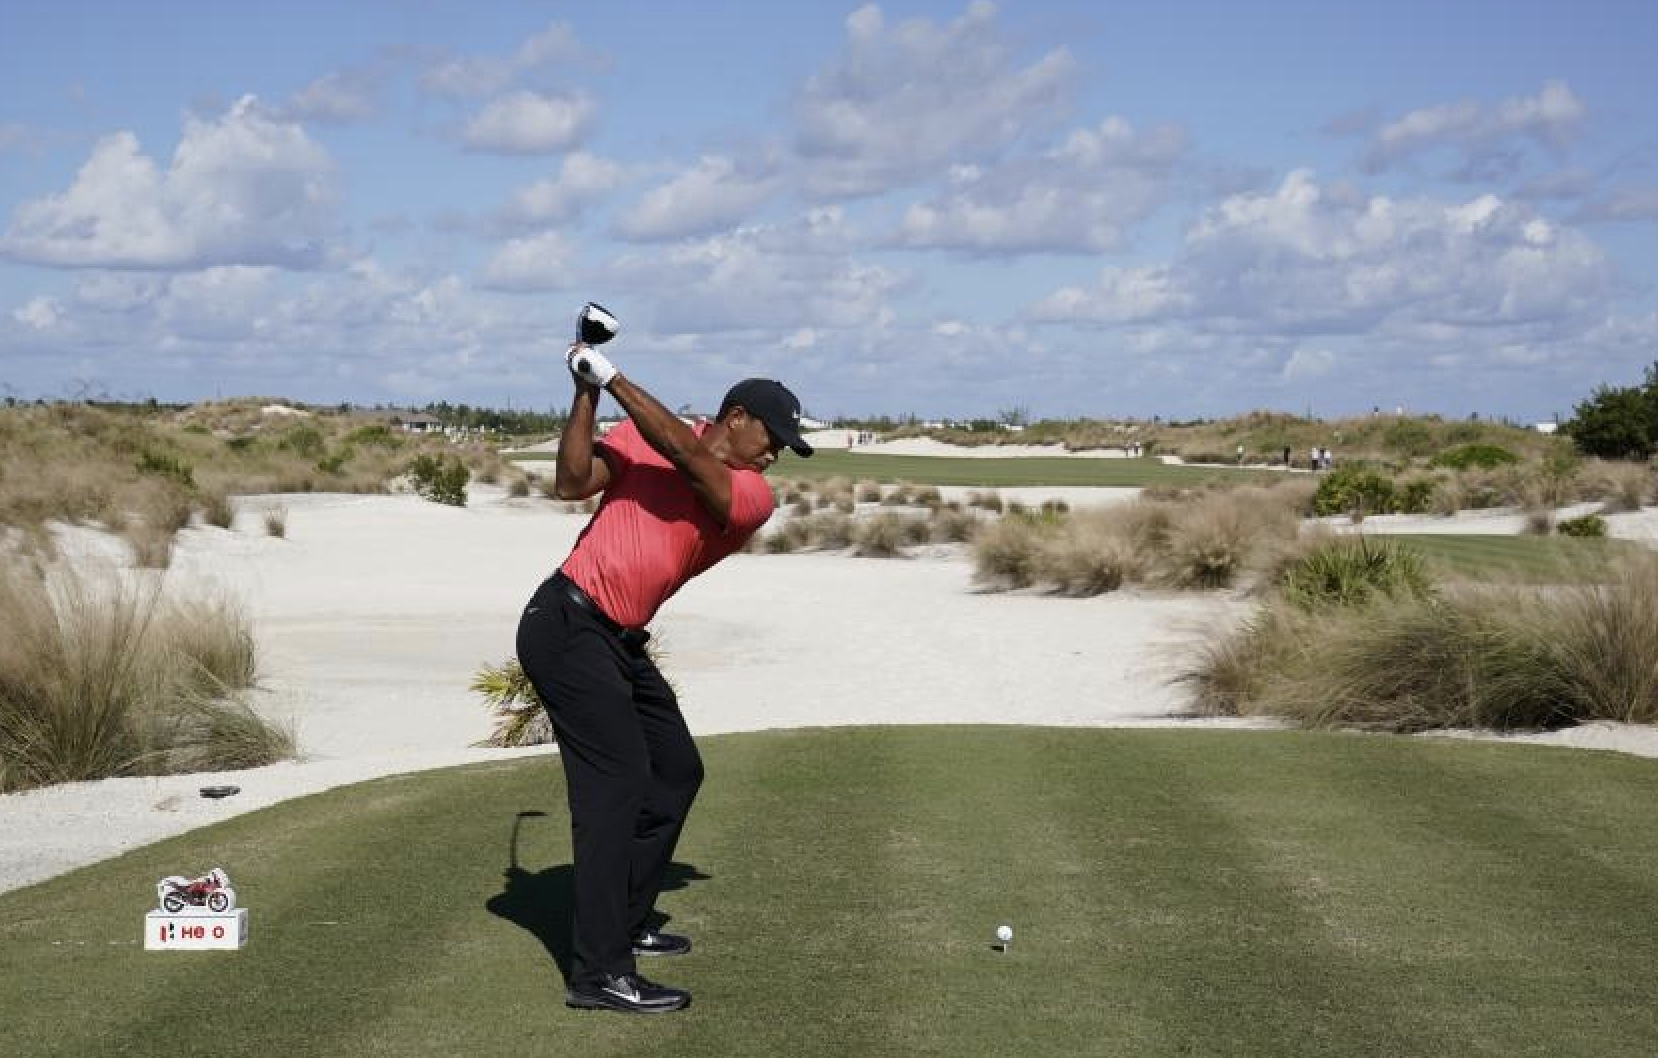

In [6]:
im = cv.imread("Tiger_Woods_crop.png")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

inWidth = im.shape[1]
inHeight = im.shape[0]

Image(filename="Tiger_Woods.png")

##The above image we are going to use to detect pose first
### so, first we need to convert image to blob

In [8]:
netInputSize = (368, 368)
inpBlob = cv.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0),swapRB=True, crop=False)
net.setInput(inpBlob)

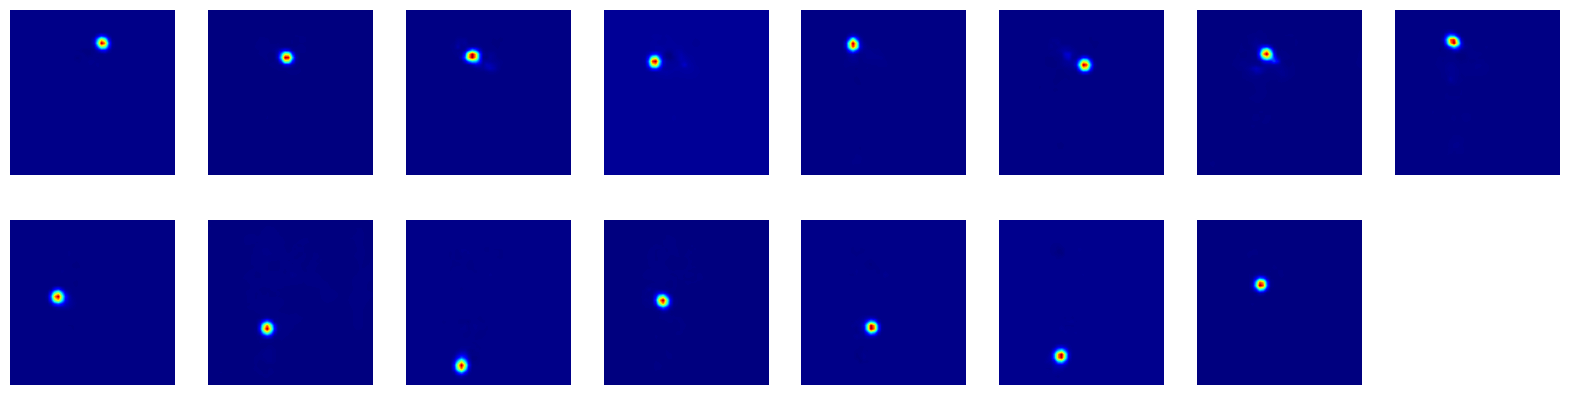

In [10]:
#Run Inference (Forward Pass)
#Forward PAss
output = net.forward()

#displaying probability maps
plt.figure(figsize=(20, 5))
for i in range(nPoints):
  probMap = output[0, i, :, :]
  displayMap = cv.resize(probMap, (inWidth, inHeight), cv.INTER_LINEAR)

  plt.subplot(2, 8, i + 1)
  plt.axis("off")
  plt.imshow(displayMap, cmap="jet")

##After that we are going to extract points from image

In [11]:
#X and Y scale
scaleX = inWidth / output.shape[3]
scaleY = inHeight / output.shape[2]

#list to store the detected points
points = []

#threshold
threshold = 0.1

for i in range(nPoints):
  #obtaining probability map
  probMap = output[0, i, :, :]

  #fnd global maxima of the probMap
  minVal, prob, minLoc, point = cv.minMaxLoc(probMap)

  #scale the point to fit on the original image
  x = scaleX * point[0]
  y = scaleY * point[1]
  if prob > threshold:
    #add the point to the list if the probability is greater than threshold
    points.append((int(x), int(y)))
  else:
    points.append(None)


##after finding the points, next step to display the points and skeleton on the image

In [12]:
imPoints = im.copy()
imSkeleton = im.copy()

#drawing points
for i, p in enumerate(points):
  cv.circle(imPoints, p, 8, (255, 255, 0), thickness=-1, lineType=cv.FILLED)
  cv.putText(imPoints, "{}".format(i), p, cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv.LINE_AA)


#draw skeleton
for pair in POSE_PAIRS:
  partA = pair[0]
  partB = pair[1]

  if points[partA] and points[partB]:
    cv.line(imSkeleton, points[partA], points[partB], (255, 255, 0), 2)
    cv.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv.FILLED)

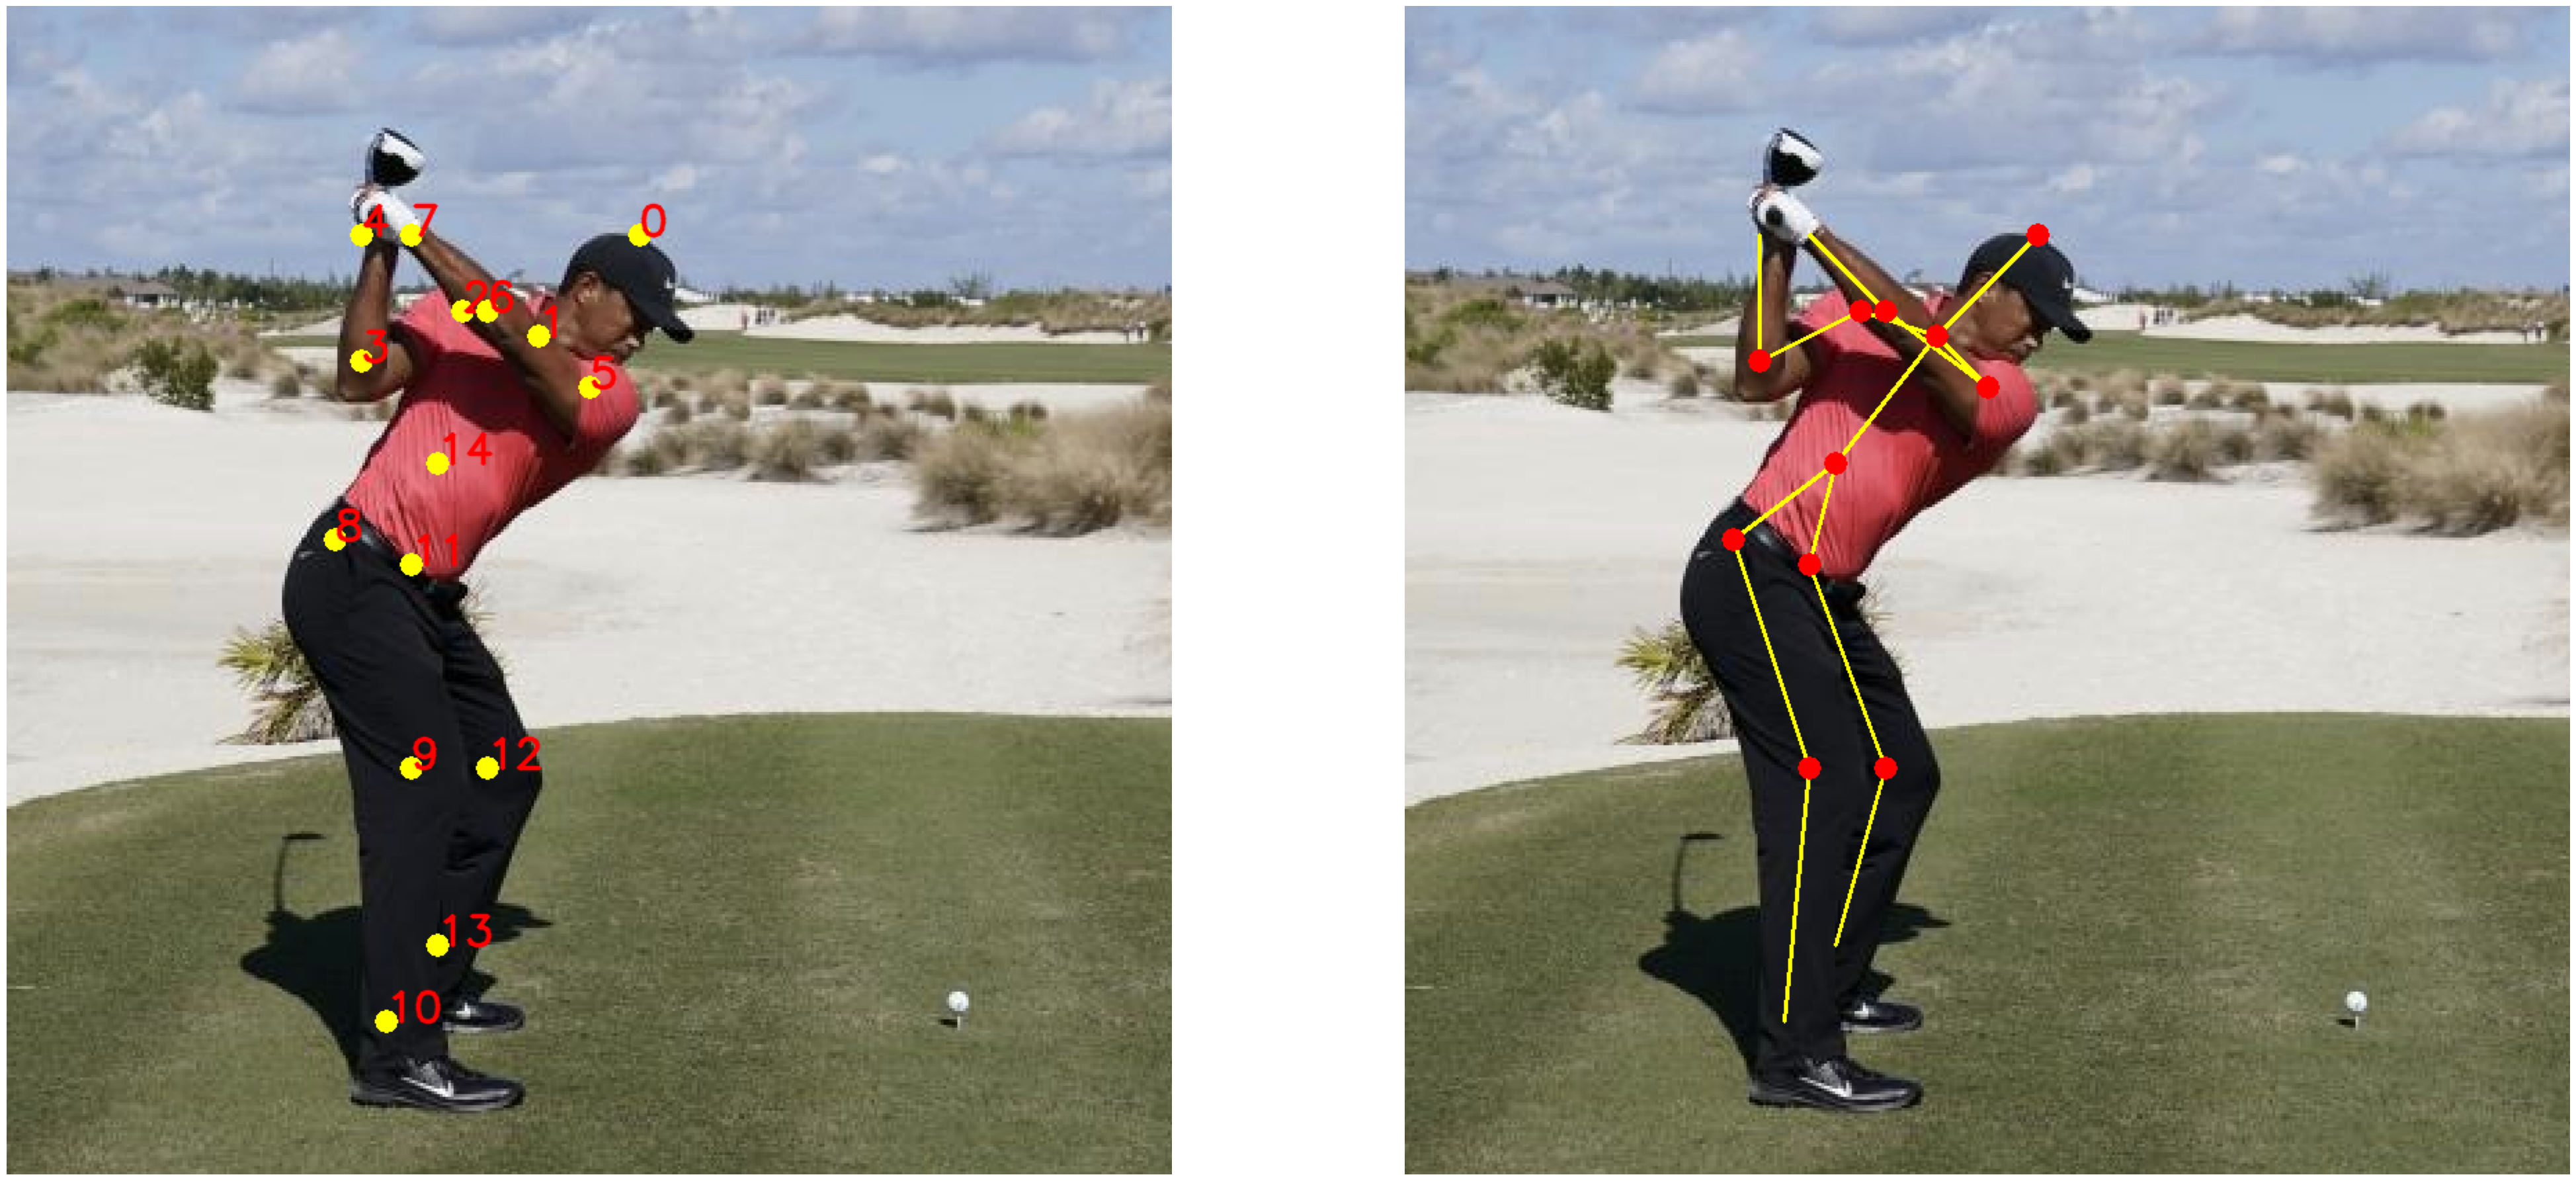

In [13]:
plt.figure(figsize=[50, 50])

plt.subplot(121)
plt.axis("off")
plt.imshow(imPoints)

plt.subplot(122)
plt.axis("off")
plt.imshow(imSkeleton)